In [3]:
import json
from datetime import datetime

In [4]:
t = '0:01:45'

time = datetime.strptime(t, '%H:%M:%S').time()
time.second

def time_to_seconds(t):
    time = datetime.strptime(t, '%H:%M:%S').time()
    return time.hour*3600 + time.minute*60 + time.second

def seconds_to_time(s):
    return datetime.utcfromtimestamp(s).strftime('%H:%M:%S')

print(time_to_seconds(t))
print(seconds_to_time(time_to_seconds(t)))

105
00:01:45


In [5]:
from collections import defaultdict

episodes_data = json.load(open('../data/raw/episodes.json', 'r'))
characters_data = json.load(open('../data/raw/characters.json', 'r'))
colors = json.load(open('../data/raw/colors.json', 'r'))
colors = colors['houses']


episodes = episodes_data['episodes']
print('Number of episodes:', len(episodes))

characters = set()
characters_by_season = {}

for episode in episodes:
    season = episode['seasonNum']
    scenes = episode['scenes']
    for scene in scenes:
        scene_length = time_to_seconds(scene['sceneEnd']) - time_to_seconds(scene['sceneStart'])
        scene['sceneLength'] = scene_length
        for character in scene['characters']:
            name = character['name']
            characters.add(name)
            if season not in characters_by_season:
                characters_by_season[season] = set()
            characters_by_season[season].add(name)

# Sort characters characters_by_season
characters = sorted(list(characters))
for season in characters_by_season:
    characters_by_season[season] = sorted(list(characters_by_season[season]))

# Create a dict of character name to color
character_colors = defaultdict(lambda: '#DBA374')
for character in characters_data['characters']:
    name = character['characterName']

    if name not in characters:
        continue
    
    if 'houseName' in character:
        if isinstance(character['houseName'], list):
            house = character['houseName'][0]
        else:
            house = character['houseName']

        if house in colors:
            character_colors[name] = colors[house]
        else:
            print("WARNING missing color for house:", house)

Number of episodes: 73
WARNING missing color for house: Arryn
WARNING missing color for house: Umber
WARNING missing color for house: Tarly


In [6]:
for c in characters:
    character_colors[c]

In [7]:
print("Number of total characters:", len(characters))
print('Number of characters per season:')
for season in characters_by_season:
    print(season, len(characters_by_season[season]))
print('\n\n')

def episodes_from_season(data, season):
    return [episode for episode in data if episode['seasonNum'] == season]

def make_matrix(episodes, characters):
    # Make a 2d matrix of characters x characters
    matrix = []
    for i in range(len(characters)):
        matrix.append([0]*len(characters))
    
    for episode in episodes:
        for scene in episode['scenes']:
            sceneLength = scene['sceneLength']
            characters_in_scene = scene['characters']
            characters_in_scene = [character['name'] for character in characters_in_scene]

            # Fill in the matrix
            for i in range(len(characters_in_scene)):
                for j in range(len(characters_in_scene)):
                    # Skip diagonal, can be recomputed as sum(row)
                    if i != j:
                        matrix[characters.index(characters_in_scene[i])][characters.index(characters_in_scene[j])] += sceneLength

    return matrix

season_1_matrix = make_matrix(episodes_from_season(episodes, 1), characters_by_season[1])
season_2_matrix = make_matrix(episodes_from_season(episodes, 2), characters_by_season[2])
season_3_matrix = make_matrix(episodes_from_season(episodes, 3), characters_by_season[3])
season_4_matrix = make_matrix(episodes_from_season(episodes, 4), characters_by_season[4])
season_5_matrix = make_matrix(episodes_from_season(episodes, 5), characters_by_season[5])
season_6_matrix = make_matrix(episodes_from_season(episodes, 6), characters_by_season[6])
season_7_matrix = make_matrix(episodes_from_season(episodes, 7), characters_by_season[7])
season_8_matrix = make_matrix(episodes_from_season(episodes, 8), characters_by_season[8])

complete_matrix = make_matrix(episodes, characters)

Number of total characters: 577
Number of characters per season:
1 125
2 137
3 137
4 152
5 175
6 208
7 75
8 66





In [8]:
total_time = 0
for episode in episodes:
    for scene in episode['scenes']:
        total_time += scene['sceneLength']
print ('Total time:', total_time)

# Calculate hours, minutes, and seconds
hours, remainder = divmod(total_time, 3600)
minutes, seconds = divmod(remainder, 60)

print(f'{hours} hours, {minutes} minutes, {seconds} seconds')


Total time: 237423
65 hours, 57 minutes, 3 seconds


In [9]:
def top_n_characters(matrix, characters, n=50):
    summed_times = [(idx, sum(row)) for (idx, row) in enumerate(matrix)]
    summed_times = sorted(summed_times, key=lambda x: x[1], reverse=True)
    top_n = summed_times[:n]
    top_n = [(characters[idx], time) for (idx, time) in top_n]
    return top_n

top_50_full = top_n_characters(complete_matrix, characters)
top_50_full

[('Tyrion Lannister', 162382),
 ('Jon Snow', 161827),
 ('Daenerys Targaryen', 134582),
 ('Sansa Stark', 124635),
 ('Cersei Lannister', 107369),
 ('Davos Seaworth', 100864),
 ('Jorah Mormont', 97254),
 ('Lord Varys', 91907),
 ('Arya Stark', 87792),
 ('Jaime Lannister', 87201),
 ('Missandei', 81637),
 ('Bran Stark', 81050),
 ('Brienne of Tarth', 80241),
 ('Sandor Clegane', 72912),
 ('Theon Greyjoy', 69569),
 ('Samwell Tarly', 68403),
 ('Grey Worm', 64867),
 ('Tormund Giantsbane', 58457),
 ('Joffrey Baratheon', 57051),
 ('Petyr Baelish', 48827),
 ('Yohn Royce', 42127),
 ('Catelyn Stark', 41527),
 ('Grand Maester Pycelle', 40894),
 ('Eddard Stark', 40189),
 ('Gendry', 40009),
 ('Gregor Clegane', 37619),
 ('Tywin Lannister', 35936),
 ('Tommen Baratheon', 35370),
 ('Podrick Payne', 34900),
 ('Barristan Selmy', 34490),
 ('Margaery Tyrell', 33797),
 ('Eddison Tollett', 32829),
 ('Qhono', 31292),
 ('Robb Stark', 31173),
 ('Bronn', 30352),
 ('Qyburn', 28818),
 ('Drogon', 28648),
 ('Mace Tyrell',

In [10]:
def normalize_matrix(matrix):
    normalized_matrix = []
    for row in matrix:
        total = sum(row)
        if total == 0:
            normalized_matrix.append(row)
            continue
        normalized_row = [val/total for val in row]
        normalized_matrix.append(normalized_row)
    return normalized_matrix

season_1_mat_norm = normalize_matrix(season_1_matrix)
season_2_mat_norm = normalize_matrix(season_2_matrix)
season_3_mat_norm = normalize_matrix(season_3_matrix)
season_4_mat_norm = normalize_matrix(season_4_matrix)
season_5_mat_norm = normalize_matrix(season_5_matrix)
season_6_mat_norm = normalize_matrix(season_6_matrix)
season_7_mat_norm = normalize_matrix(season_7_matrix)
season_8_mat_norm = normalize_matrix(season_8_matrix)
complete_mat_norm = normalize_matrix(complete_matrix)

In [30]:
def is_symmetrical(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if matrix[i][j] != matrix[j][i]:
                return False
    return True

def matrix_eye(matrix):
    eye = [matrix[i][i] for i in range(len(matrix))]
    return any(eye)

print(is_symmetrical(season_1_mat_norm))
print(is_symmetrical(season_2_mat_norm))
print(is_symmetrical(season_3_mat_norm))
print(is_symmetrical(season_4_mat_norm))
print(is_symmetrical(season_5_mat_norm))
print(is_symmetrical(season_6_mat_norm))
print(is_symmetrical(season_7_mat_norm))
print(is_symmetrical(season_8_mat_norm))
print(is_symmetrical(complete_mat_norm))

print('--------------')
print(matrix_eye(season_1_mat_norm))
print(matrix_eye(season_2_mat_norm))
print(matrix_eye(season_3_mat_norm))
print(matrix_eye(season_4_mat_norm))
print(matrix_eye(season_5_mat_norm))
print(matrix_eye(season_6_mat_norm))
print(matrix_eye(season_7_mat_norm))
print(matrix_eye(season_8_mat_norm))
print(matrix_eye(complete_mat_norm))


False
False
False
False
False
False
False
False
False
--------------
False
False
False
False
False
False
False
False
False


We have 2 connected components


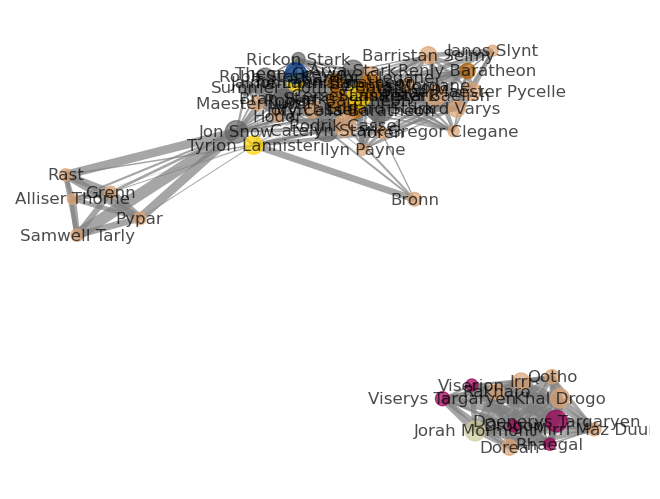

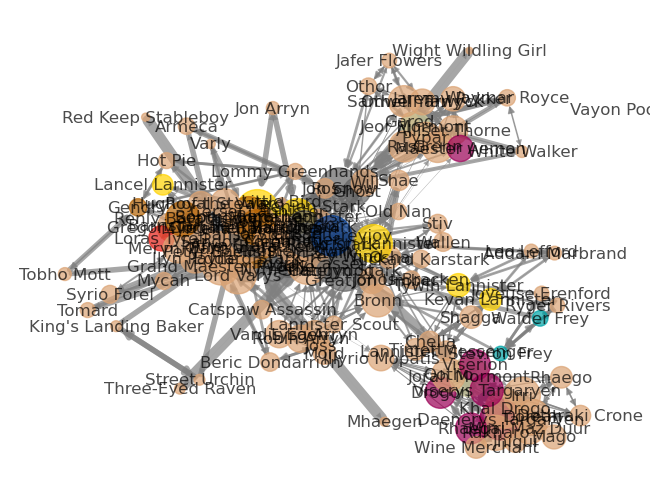

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from math import pi, sqrt

def make_graph(matrix_full, characters):
    matrix_norm = normalize_matrix(matrix_full)
    G = nx.Graph()
    for (idx, row) in enumerate(matrix_full):
        total_time = sum(row)
        G.add_node(characters[idx], total_time=total_time)
    
    for i in range(len(characters)):
        for j in range(len(characters)):
            if i != j:
                time_norm = matrix_norm[i][j]
                if time_norm == 0.0:
                    continue
                G.add_edge(characters[i], characters[j], time_norm=time_norm)
    return G

def make_digraph(matrix_full, characters):
    matrix_norm = normalize_matrix(matrix_full)
    DG = nx.DiGraph()
    for (idx, row) in enumerate(matrix_full):
        total_time = sum(row)
        DG.add_node(characters[idx], total_time=total_time)
    
    for i in range(len(characters)):
        for j in range(len(characters)):
            if i != j:
                time_norm = matrix_norm[i][j]
                if time_norm == 0.0:
                    continue
                DG.add_edge(characters[i], characters[j], interaction_time=time_norm)
    return DG

def area_to_radius(area):
    return  (area / pi)**0.5

def color_nodes(G):
    colors = []
    for node in G.nodes():
        colors.append(character_colors[node])
    return colors

def draw_graph(G):
    node_sizes = nx.get_node_attributes(G, 'total_time').values()
    node_sizes = [v*0.01 for v in node_sizes]
    edges = G.edges()
    widths = [G[u][v]['time_norm'] * 35 for u,v in edges]
    k = 1 / sqrt(len(G.nodes())) * 4
    nx.draw(G,
            pos=nx.spring_layout(G, k=k),
            with_labels=True,
            edge_color='grey',
            node_size=node_sizes,
            node_color=color_nodes(G),
            alpha=.7,
            font_color='black',
            width=widths,
    )

def draw_digraph(G):
    node_sizes = nx.get_node_attributes(G, 'total_time').values()
    node_sizes = [area_to_radius(v) * 10 for v in node_sizes]
    edge_widths = [G[u][v]['interaction_time'] * 8 for u,v in G.edges()]
    k = 1 / sqrt(len(G.nodes())) * 5
    nx.draw(G,
            pos=nx.spring_layout(G, k=k),
            with_labels=True,
            edge_color='grey',
            node_size=node_sizes,
            node_color=color_nodes(G),
            alpha=.7,
            font_color='black',
            width=edge_widths,
    )

G_S1 = make_graph(season_1_matrix, characters_by_season[1])

# Limit to top 50 notes
nodes = G_S1.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]['total_time'], reverse=True)[:50]
G_S1 = G_S1.subgraph([node[0] for node in nodes])
DG_S1 = make_digraph(season_1_matrix, characters_by_season[1])
print("We have", nx.number_connected_components(G_S1), "connected components")


plt.figure(1)
draw_graph(G_S1)
plt.figure(2)
draw_digraph(DG_S1)  
plt.show()

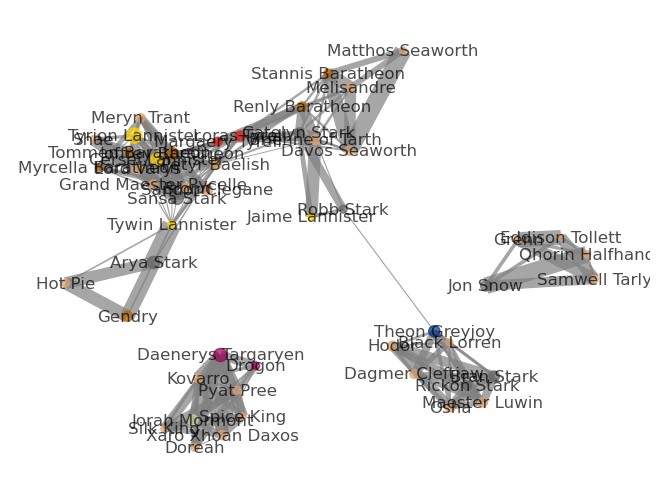

In [13]:
G_S2 = make_graph(season_2_matrix, characters_by_season[2])

# Limit to top 50 notes
nodes = G_S2.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]['total_time'], reverse=True)[:50]

G_S2 = G_S2.subgraph([node[0] for node in nodes])
draw_graph(G_S2)

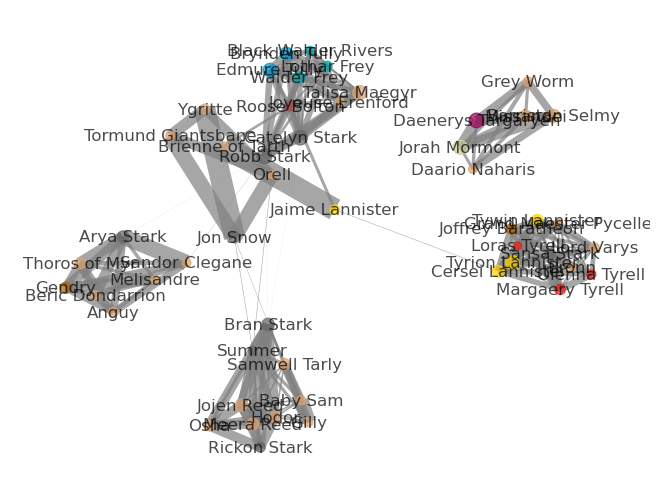

In [14]:
G_S3 = make_graph(season_3_matrix, characters_by_season[3])

# Limit to top 50 notes
nodes = G_S3.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]['total_time'], reverse=True)[:50]

G_S3 = G_S3.subgraph([node[0] for node in nodes])
draw_graph(G_S3)

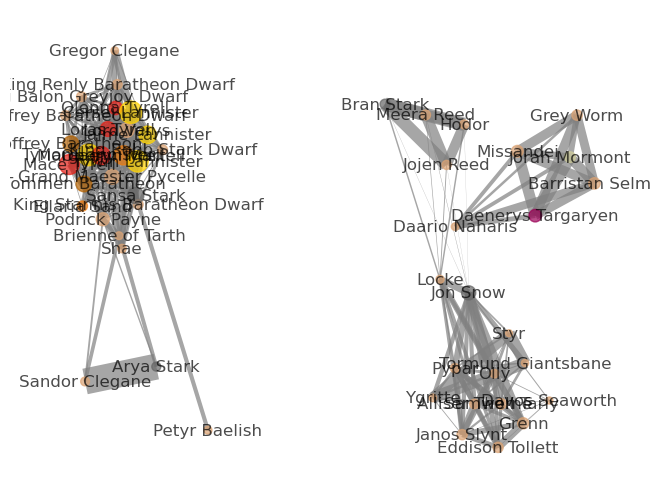

In [15]:
G_S4 = make_graph(season_4_matrix, characters_by_season[4])

# Limit to top 50 notes
nodes = G_S4.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]['total_time'], reverse=True)[:50]

G_S4= G_S4.subgraph([node[0] for node in nodes])
draw_graph(G_S4)

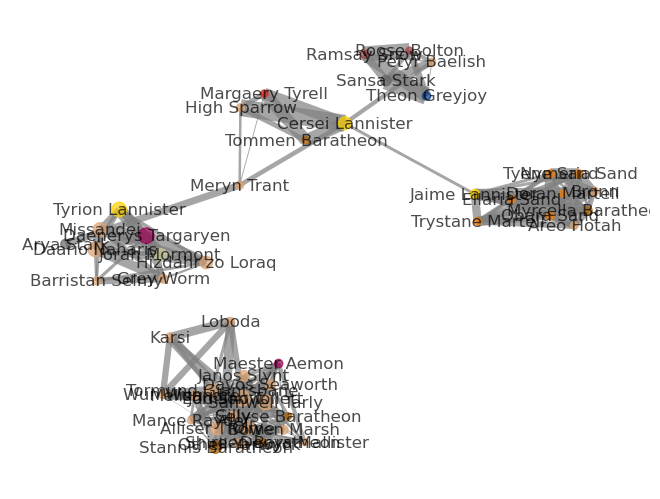

In [16]:
G_S5 = make_graph(season_5_matrix, characters_by_season[5])

# Limit to top 50 notes
nodes = G_S5.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]['total_time'], reverse=True)[:50]

G_S5= G_S5.subgraph([node[0] for node in nodes])
draw_graph(G_S5)

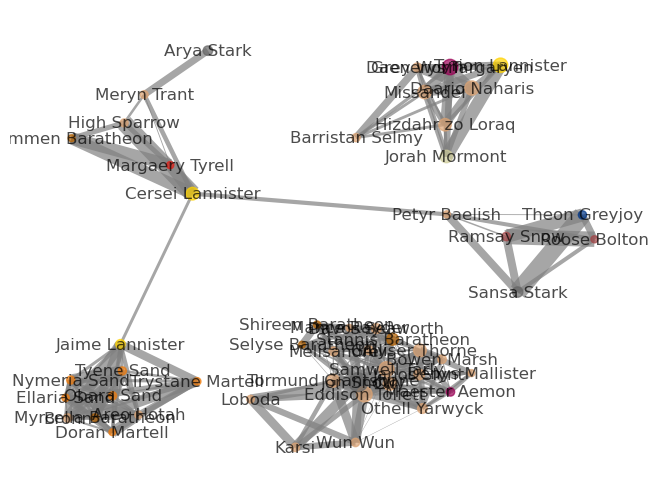

In [17]:
G_S8 = make_graph(season_8_matrix, characters_by_season[8])

# Limit to top 50 notes
nodes = G_S8.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]['total_time'], reverse=True)[:50]

G_S8= G_S8.subgraph([node[0] for node in nodes])
draw_graph(G_S5)

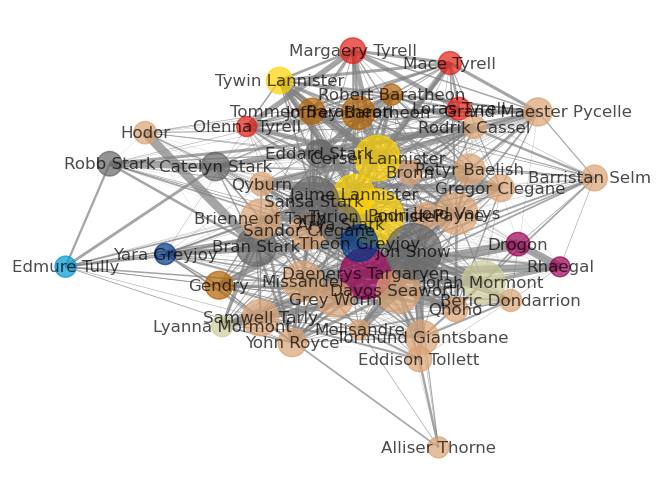

In [18]:
G_complete = make_graph(complete_matrix, characters)

# Limit to top 50 notes
nodes = G_complete.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]['total_time'], reverse=True)[:50]

G_complete= G_complete.subgraph([node[0] for node in nodes])
draw_graph(G_complete)

# Degree Distribution, Centrality and other measures

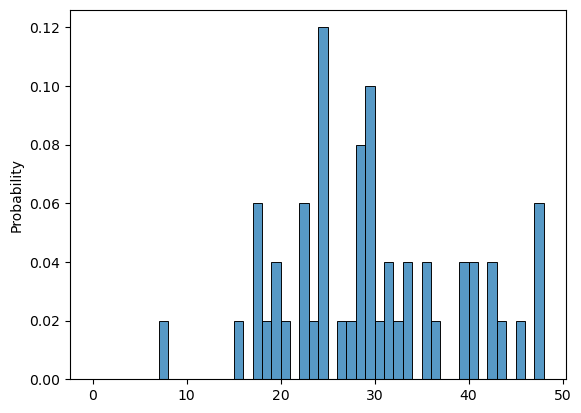

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

complete_degree_sequence = [d for _, d in G_complete.degree()]

#plt.hist(complete_degree_sequence, bins=range(0, max(complete_degree_sequence) + 1), density=True, alpha=0.75, rwidth=0.85)
#plt.xlabel('Degree')
#plt.ylabel('Probability')
#plt.title('Degree Distribution of ER Network')
#plt.grid(axis='y', linestyle='--')

sns.histplot(complete_degree_sequence, bins=range(0, max(complete_degree_sequence) + 1))
plt.show()